In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import RobustScaler
import pickle

In [ ]:
def get_fish_column(fish, size, market):

    fish_mapping = {
       'Indian Mackerel': 'Indian_Mackerel',
       'Rock Lobster': 'Rock_Lobster',
       'Silver Pomfret': 'Silver_Pomfret',
       'Indian White Prawn':'Indian_White_Prawn',
       'Spotted Crab':'Spotted_Crab',
       'Indo Pacific Seer Fish':'Indo_Pacific_Seer_Fish',
       'Johns Snapper':'Johns_Snapper'
    }
    size_mapping = {
        "Small": "Small",
        "Medium": "Medium",
        "Large": "Large"
    }
    market_mapping = {
        "Mohanpura Modern Fish Market": "MarketA",
        "Venlok Fish Market": "MarketB",
        "Visakhapatnam Municipal Wholesale Fish Market": "MarketC",
        "Ghoghla Retail Fish Market": "MarketD",
        "Vanakbara Retail Fish Market": "MarketE",
        "Mapusa Fish Market": "MarketF",
        "SGPDA Wholesale Fish Market": "MarketG",
        "Madikeri Retail Fish Market": "MarketH",
        "Padubidri Retail Fish Market":"MarketI",
        "Kavanad Retail Fish Market":"MarketJ",
        "Ponnani Harbour Azheekkal":"MarketK",
        "Panvel Fish Market":"MarketL",
        "Sasoon Dock Retail Fish Market":"MarketM",
        "Naya Bazar Retail Fish Market":"MarketN",
        "Unit-4 Wholesale Fish Market":"MarketO",
        "Badagada Retail Fish Market":"MarketP",
        "Chintadripet Fish Market":"MarketQ",
        "Kasivillangi Fish Market":"MarketR",
        "Nelpattai Fish Market":"MarketS",

    }

    if fish in fish_mapping and size in size_mapping and market in market_mapping:
        return f"{fish_mapping[fish]}_{size_mapping[size]}_{market_mapping[market]}"
    else:
        return "Incorrect Input"


In [ ]:
def predict(fore_date, market, fish, size):

    train_data = pd.read_excel("all_states_aggregate.xlsx")
    train_data.dropna(subset=['Date'], inplace=True)
    train_data['Date'] = pd.to_datetime(train_data['Date'], format='%d-%m-%Y', errors='coerce')
    full_dates = pd.DataFrame({'Date': pd.date_range(start=train_data['Date'].min(), end=train_data['Date'].max(), freq='D')})
    train_data = full_dates.merge(train_data, on='Date', how='left')
    train_data.set_index('Date', inplace=True)
    for col in train_data.columns:
        train_data[col] = pd.to_numeric(train_data[col], errors='coerce')
    train_data.replace(0, np.nan, inplace=True)
    # train_data = train_data.interpolate(method="polynomial", order=2, limit_direction="both")
    train_data = train_data.interpolate(method="linear", limit_direction="both")
    for col in train_data.columns:
        train_data[col] = train_data[col].fillna(train_data[col].median())
    for col in train_data.columns:
        if (train_data[col] < 0).any():
            smooth_mean = train_data.loc[train_data[col] > 0, col].mean()
            train_data[col] = train_data[col].apply(lambda x: x if x > 0 else smooth_mean)

    scaler = RobustScaler()
    train_scaled = pd.DataFrame(scaler.fit_transform(train_data),
                                columns=train_data.columns,
                                index=train_data.index)

    baseline_date = datetime.strptime("07-03-2025", "%d-%m-%Y")
    with open('model_ann.pkl', 'rb') as file:
        model = pickle.load(file)

    if fore_date < baseline_date:
        return "enter dates after 7th March,2025 only"

    steps = (fore_date - baseline_date).days

    input_data = train_scaled.values[-90:].reshape(1, 90, -1)
    forecast_scaled = []
    for _ in range(steps):
        pred = model.predict(input_data)
        forecast_scaled.append(pred[0])
        new_input = np.concatenate([input_data[0][1:], pred], axis=0)
        input_data = new_input.reshape(1, 90, -1)

    forecast = scaler.inverse_transform(forecast_scaled)
    forecast_dates = [baseline_date + timedelta(days=i + 1) for i in range(steps)]
    forecast_data = pd.DataFrame(forecast, columns=train_data.columns, index=forecast_dates)

    fish_and_size = get_fish_column(fish, size, market)
    if fish_and_size not in forecast_data.columns:
        return "Incorrect Input"
    fish_data = forecast_data[fish_and_size]
    forecast_dates = []
    final_forecast_data = {
        'Date': [],
        'Prediction': []
    }
    print("Forecast of Fish Prices ")
    for i in range(len(fish_data)):
        current_date = baseline_date + timedelta(days=i + 1)
        print("Date {} Prediction {} Rupees".format(current_date.strftime("%d-%m-%y"), np.round(fish_data[i])))
        forecast_dates.append(current_date)
        final_forecast_data['Date'].append(current_date)
        final_forecast_data['Prediction'].append(np.round(fish_data[i]))
    plt.plot(train_data.index, train_data[fish_and_size], label="Historical Data", color="blue")
    plt.plot(forecast_dates, fish_data, label="Forecast Data", linestyle="--", color="red")
    plt.xticks(rotation=45)
    # plt.ylim(0, 2000)
    plt.legend()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

<ipython-input-5-deddc5046d72>:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Date {} Prediction {} Rupees".format(current_date.strftime("%d-%m-%y"), np.round(fish_data[i])))
<ipython-input-5-deddc5046d72>:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_forecast_data['Prediction'].append(np.round(fish_data[i]))


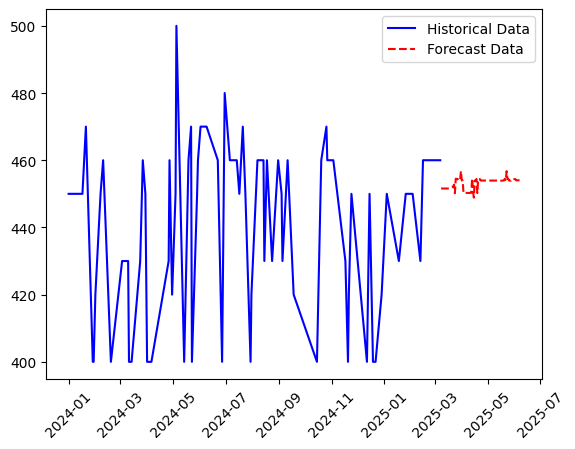

In [ ]:
predict(datetime.strptime("07-06-2025", "%d-%m-%Y"),"Nelpattai Fish Market","Indian White Prawn","Medium")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━

<ipython-input-5-deddc5046d72>:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Date {} Prediction {} Rupees".format(current_date.strftime("%d-%m-%y"), np.round(fish_data[i])))
<ipython-input-5-deddc5046d72>:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_forecast_data['Prediction'].append(np.round(fish_data[i]))


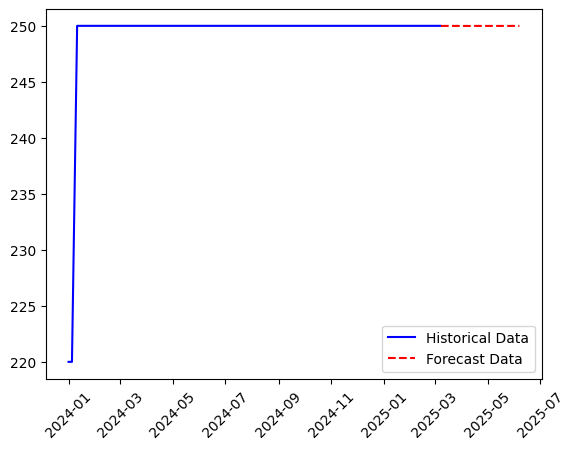

In [ ]:
predict(datetime.strptime("07-06-2025", "%d-%m-%Y"),"SGPDA Wholesale Fish Market","Johns Snapper","Small")